In [31]:
# Omid55
import numpy as np
import pandas as pd
import math
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from time import time
% matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def visualize_hierarchical_clusters(data, NUMBER_OF_CLUSTERS, metric='cosine'):

    X = np.asmatrix(data.ix[:,:-1])
    y = np.asanyarray(data['label'])
    #----------------------------------------------------------------------
    # Visualize the clustering
    def plot_clustering(X_red, X, labels, title=None):
        x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
        X_red = (X_red - x_min) / (x_max - x_min)

        plt.figure(figsize=(6, 4))
        for i in range(X_red.shape[0]):
            plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                     color=plt.cm.spectral(labels[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})

        plt.xticks([])
        plt.yticks([])
        if title is not None:
            plt.title(title, size=17)
        plt.axis('off')
        plt.tight_layout()

    #----------------------------------------------------------------------
    # 2D embedding of the digits dataset
    print("Computing embedding")
    X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
    print("Done.")

    if metric == 'euclidean':
        linkages = ['ward', 'average', 'complete']
    else:
        linkages = ['average', 'complete']

    for linkage in linkages:
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS)
        t0 = time()
        clustering.fit(X_red)
        print("%s : %.2fs" % (linkage, time() - t0))
        plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

    plt.show()

    
def normalize_the_dataset(dataset):

	# MIN MAX Normalization
	#x = dataset.values #returns a numpy array
	#min_max_scaler = preprocessing.MinMaxScaler()
	#x_scaled = min_max_scaler.fit_transform(x)
	#dataset = pd.DataFrame(x_scaled)

	# Standard Normalization (x-mean(x) / std(x))
	x = dataset.values[:,:-1] #returns a numpy array
	min_max_scaler = StandardScaler()
	x_scaled = min_max_scaler.fit_transform(x)
	dataset = pd.DataFrame(np.column_stack((x_scaled,dataset.values[:,-1])), columns=dataset.columns)

	return dataset


def plot_data(data, has_label=True):
	if not has_label:
		data = data.copy()
		data['label'] = np.zeros([len(data),1])

	LIMIT = 4000
	if data.shape[0] > LIMIT:
		dt = data.sample(n=LIMIT, replace=False)
		X = dt.ix[:,:-1]
		labels = dt.ix[:,-1]
	else:
		X = data.ix[:,:-1]
		labels = data.ix[:,-1]

	tsne_model = TSNE(n_components=2, random_state=0)
	np.set_printoptions(suppress=True)
	points1 = tsne_model.fit_transform(X)
	df1 = pd.DataFrame(data=np.column_stack([points1,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df1, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('TNSE')

	pca = PCA(n_components=2)
	pca.fit(X)
	points2 = pca.transform(X)
	df2 = pd.DataFrame(data=np.column_stack([points2,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df2, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('PCA')


def dropnans_from_dataset(dataset):
	to_be_deleted = []
	for idx,item in enumerate(dataset.as_matrix()):
	    if np.isnan(item).any():
	        to_be_deleted.append(idx)
	dataset = dataset.drop(to_be_deleted)
	return dataset


def do_classification(dataset):
    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [#(DummyClassifier(strategy='stratified'), 'Dummy (Stratified)'),
        (DummyClassifier(strategy='uniform'), 'Dummy (Uniform)'),
        (SGDClassifier(), 'Stochastic Gradient Descent Classifier'),
        (LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    #print(print_class_ratio(dataset))
    #print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    train_accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)

            # test data accuracy
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent

            # train data accuracy
            y_train_pred = clf.predict(X_train)
            train_accuracy_percent = 100 * sk.metrics.accuracy_score(y_train, y_train_pred) / n_folds
            if name not in train_accuracy:
                train_accuracy[name] = train_accuracy_percent
            else:
                train_accuracy[name] += train_accuracy_percent
        result = []
        for key in accuracy.keys():
            result.append([key, round(accuracy[key],2), round(train_accuracy[key],2)])
        result_accuracy_df = pd.DataFrame(data=result, columns=['classifier', 'test acc', 'train acc'])
    return result_accuracy_df


def run(file_name):
	original_data = pd.read_csv(file_name)
	print(original_data.shape)
	original_data = original_data.drop(original_data.columns[0], 1)
	original_data = dropnans_from_dataset(original_data)
	sampled_data = original_data #original_data.sample(n=500)

	# Adding label and swapping 50% of winners and losers ;Thus:
	#   label 0 == winner + loser
	#   label 1 == loser + winner
	dataset = sampled_data.copy()
	dataset['label'] = np.zeros([len(dataset),1])
	dt = dataset.as_matrix()
	idx = np.random.choice(len(dt), int(len(dt)/2), replace=False)
	tf = math.floor(dt.shape[1]/2)
	tmp = dt[idx,tf:2*tf]
	dt[idx,tf:2*tf] = dt[idx,:tf]
	dt[idx,:tf] = tmp
	dt[idx,-1] = 1
	dataset = pd.DataFrame(data=dt, columns=dataset.columns)

	dataset = normalize_the_dataset(dataset)
	#print(dataset.head())

	plot_data(dataset)

	visualize_hierarchical_clusters(dataset, 2)
	#visualize_hierarchical_clusters(dataset, 3)
	#visualize_hierarchical_clusters(dataset, 4)

	print(do_classification(dataset))



# RUN

(178, 21)


/cs/student/omid55/.local/lib/python2.7/site-packages/ipykernel/__main__.py:205: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/cs/student/omid55/.local/lib/python2.7/site-packages/ipykernel/__main__.py:206: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/cs/student/omid55/.local/lib/python2.7/site-packages/ipykernel/__main__.py:207: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Computing embedding
Done.
average : 0.01s
complete : 0.01s


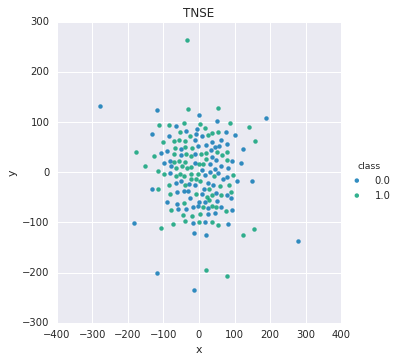

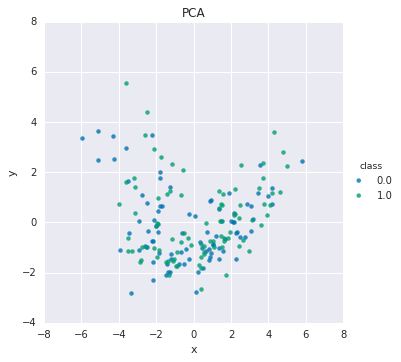

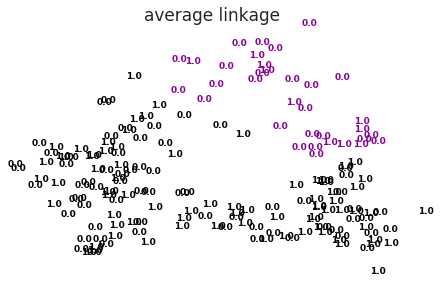

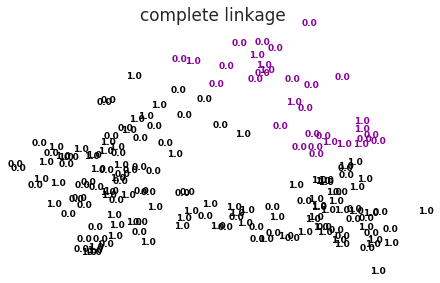

                                classifier  test acc  train acc
0                                      KNN     55.00      64.11
1          Quadratic Discriminant Analysis     51.60      73.72
2                            Decision Tree     52.78      83.33
3             Linear Discriminant Analysis     57.32      67.60
4                      SVM with RBF kernel     57.75      75.59
5                              Naive Bayes     53.27      61.74
6                               Linear SVM     58.95      67.29
7                            Random Forest     55.03     100.00
8   Stochastic Gradient Descent Classifier     47.81      55.24
9                                 AdaBoost     51.11      91.82
10                     Logistic Regression     61.80      66.79
11                         Dummy (Uniform)     53.43      51.38


In [38]:
run('Classification2016_Dataset.csv')